This will autoload the new/updated packages

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
import sys
sys.platform

'win32'

This is the batch size

In [4]:
bs = 100
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

Function to read from JSON file

In [5]:
def readJSONFile(path):
    import json
    with open(path) as f:
        data = json.load(f)
    return data

In [6]:
path=sys.platform=="Linux" and '/home/manoj/Documents/data/data1/iwildcam-2020' or 'C:\\Users\\manoj\\PycharmProjects\\data\\iwildcam-2020'
dataPath=Path(path)


In [7]:
jsonFilePath=dataPath/'iwildcam2020_train_annotations.json'

In [8]:
data = readJSONFile(jsonFilePath)

annotations = data["annotations"]
images=data["images"]
categories = data["categories"]
info = data["info"]

# Convert to Data frame

annotations = pd.DataFrame.from_dict(annotations)
images = pd.DataFrame.from_dict(images)
categories = pd.DataFrame.from_dict(categories)


#Remove data from memory
del data

#Create column image_id to use for merging the two data frames
images["image_id"]  = images["id"]

# Merge annotations and images on image_id

trainDf1 = (pd.merge(annotations, images, on='image_id'))
#Remove Unnecessary fields
trainDf1.drop(["id_y","id_x"], axis = 1, inplace=True)

#print(trainDf1.columns)

trainDf1 = pd.merge(trainDf1, categories.rename(columns={"id":"category_id"}), on="category_id" )
# Unset annotations and images dataframe as they are no longer needed
del annotations
#del images


In [9]:
jsonMegFilePath=dataPath/"iwildcam2020_megadetector_results.json"

In [10]:
megData = readJSONFile(jsonMegFilePath)

In [11]:
megImages=pd.DataFrame(megData["images"])
megImages

,detections,id,max_detection_conf
0,"[{'category': '1', 'bbox': [0.6529, 0.5425, 0....",905a3c8c-21bc-11ea-a13a-137349068a90,0.999
1,"[{'category': '1', 'bbox': [0.0147, 0.0, 0.985...",905a3fc0-21bc-11ea-a13a-137349068a90,0.696
2,[],905a420e-21bc-11ea-a13a-137349068a90,0.000
3,"[{'category': '1', 'bbox': [0.0, 0.4669, 0.185...",905a4416-21bc-11ea-a13a-137349068a90,1.000
4,"[{'category': '1', 'bbox': [0.0, 0.0494, 0.528...",905a579e-21bc-11ea-a13a-137349068a90,0.999
...,...,...,...
280805,[],883cb340-21bc-11ea-a13a-137349068a90,0.000
280806,"[{'category': '1', 'bbox': [0.631, 0.5972, 0.3...",883cda5a-21bc-11ea-a13a-137349068a90,1.000
280807,"[{'category': '1', 'bbox': [0.0979, 0.3808, 0....",883ceeaa-21bc-11ea-a13a-137349068a90,0.999
280808,[],883cf54e-21bc-11ea-a13a-137349068a90,0.000


In [12]:
megImagesDf=[
 n[0] 
    and {"id":n[1], "confidence":n[2], "bbox": n[0][0]["bbox"] }
    or  {"id":n[1], "confidence":n[2], "bbox": [] }
 for i,n in enumerate(np.asarray(megImages))
]
megImagesDf=pd.DataFrame(megImagesDf)
display(megImagesDf)

,id,confidence,bbox
0,905a3c8c-21bc-11ea-a13a-137349068a90,0.999,"[0.6529, 0.5425, 0.3471, 0.4038]"
1,905a3fc0-21bc-11ea-a13a-137349068a90,0.696,"[0.0147, 0.0, 0.9853, 1.0]"
2,905a420e-21bc-11ea-a13a-137349068a90,0.000,[]
3,905a4416-21bc-11ea-a13a-137349068a90,1.000,"[0.0, 0.4669, 0.1853, 0.4238]"
4,905a579e-21bc-11ea-a13a-137349068a90,0.999,"[0.0, 0.0494, 0.5288, 0.7395]"
...,...,...,...
280805,883cb340-21bc-11ea-a13a-137349068a90,0.000,[]
280806,883cda5a-21bc-11ea-a13a-137349068a90,1.000,"[0.631, 0.5972, 0.369, 0.1746]"
280807,883ceeaa-21bc-11ea-a13a-137349068a90,0.999,"[0.0979, 0.3808, 0.3491, 0.2415]"
280808,883cf54e-21bc-11ea-a13a-137349068a90,0.000,[]


In [13]:
images

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name,image_id
0,1,267,2013-08-08 11:45:00.000,96b00332-21bc-11ea-a13a-137349068a90,1,96b004ea-21bc-11ea-a13a-137349068a90,1795,1222,96b00332-21bc-11ea-a13a-137349068a90.jpg,96b00332-21bc-11ea-a13a-137349068a90
1,1,264,2013-08-01 22:31:00.000,879d74d8-21bc-11ea-a13a-137349068a90,1,879d7654-21bc-11ea-a13a-137349068a90,2739,1772,879d74d8-21bc-11ea-a13a-137349068a90.jpg,879d74d8-21bc-11ea-a13a-137349068a90
2,1,45,2013-04-17 11:15:00.000,9017f7aa-21bc-11ea-a13a-137349068a90,1,9017f8cc-21bc-11ea-a13a-137349068a90,1891,1222,9017f7aa-21bc-11ea-a13a-137349068a90.jpg,9017f7aa-21bc-11ea-a13a-137349068a90
3,1,45,2013-04-23 08:26:00.000,90d93c58-21bc-11ea-a13a-137349068a90,1,90d93e38-21bc-11ea-a13a-137349068a90,1795,1222,90d93c58-21bc-11ea-a13a-137349068a90.jpg,90d93c58-21bc-11ea-a13a-137349068a90
4,1,45,2013-04-24 13:51:00.000,887cd0ec-21bc-11ea-a13a-137349068a90,1,887cd29a-21bc-11ea-a13a-137349068a90,1812,1196,887cd0ec-21bc-11ea-a13a-137349068a90.jpg,887cd0ec-21bc-11ea-a13a-137349068a90
...,...,...,...,...,...,...,...,...,...,...
217954,-1,218,2013-08-01 11:39:03.000,8b7899a2-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,8b7899a2-21bc-11ea-a13a-137349068a90.jpg,8b7899a2-21bc-11ea-a13a-137349068a90
217955,-1,218,2013-08-01 11:39:04.000,958f609c-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,958f609c-21bc-11ea-a13a-137349068a90.jpg,958f609c-21bc-11ea-a13a-137349068a90
217956,-1,218,2013-08-01 11:39:05.000,93bd2ede-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,93bd2ede-21bc-11ea-a13a-137349068a90.jpg,93bd2ede-21bc-11ea-a13a-137349068a90
217957,-1,218,2013-08-01 11:39:07.000,8971956e-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,8971956e-21bc-11ea-a13a-137349068a90.jpg,8971956e-21bc-11ea-a13a-137349068a90


In [14]:
megImages=pd.merge(images, megImagesDf.rename(columns={"id":"image_id"}), how="left", on = "image_id" )
#megImages["bbox"]=megImages["bbox"].fillna([0,0,0,0])
megImages=megImages.fillna({"bbox":0, "confidence":0.000})

In [15]:
megImages.isnull().values.any()
megImages[megImages.isnull()["bbox"]]
#megImages[megImages["bbox"]==0]

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name,image_id,confidence,bbox


In [16]:
megImagesDf[megImagesDf["id"]=="905a3c8c-21bc-11ea-a13a-137349068a90"]["bbox"][0]

[0.6529, 0.5425, 0.3471, 0.4038]

In [17]:
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox
import numpy as np
import os

file=str(dataPath/'train/905a3c8c-21bc-11ea-a13a-137349068a90.jpg')

In [18]:
bbox=[0.6529, 0.5425, 0.3471, 0.4038]

images[images["file_name"]=="905a3c8c-21bc-11ea-a13a-137349068a90.jpg"]

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name,image_id
208491,-1,440,2013-07-27 07:44:44.000,905a3c8c-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1920,1080,905a3c8c-21bc-11ea-a13a-137349068a90.jpg,905a3c8c-21bc-11ea-a13a-137349068a90


In [19]:
from PIL import Image, ImageOps
import cv2

def detectAndResize(filetoProcess,bbox):
    ##Resizing Images using Pillow

    if(os.path.exists(filetoProcess)==True):
        image = Image.open(filetoProcess)
        if(bbox and bbox!=0):
            W,H=image.size
            x,y,w,h = bbox

            x=int(x*W)
            y=int(y*H)
            w=int(w*W)
            h=int(h*H)
            w=w+x
            h=h+y

            box = (x, y, w, h)
            image = image.crop(box)

        image.thumbnail((400, 400))

        w1,h1=image.size

        padding = (0, 0, 400-w1, 400-h1)
        image = ImageOps.expand(image, padding)
        #image.imshow()
        #plt.imshow(image)
        #plt.show()
        image.save(str(dataPath)+"/train/400/"+os.path.basename(filetoProcess))


In [20]:
for fileNm, boundingBox in np.asarray(megImages[:][["file_name","bbox"]]):
    #print((fileNm, boundingBox))
    try:
        detectAndResize(str(dataPath/("train/"+fileNm)),boundingBox)
    except:
        print((fileNm, boundingBox))
        continue

('929da9de-21bc-11ea-a13a-137349068a90.jpg', 0)
('9631e6a0-21bc-11ea-a13a-137349068a90.jpg', 0)
('8c3a31fc-21bc-11ea-a13a-137349068a90.jpg', 0)
('88313344-21bc-11ea-a13a-137349068a90.jpg', 0)
('8c53e822-21bc-11ea-a13a-137349068a90.jpg', 0)
('911848a8-21bc-11ea-a13a-137349068a90.jpg', 0)
('98bd006c-21bc-11ea-a13a-137349068a90.jpg', 0)
('91ba7b50-21bc-11ea-a13a-137349068a90.jpg', 0)
('9799f64a-21bc-11ea-a13a-137349068a90.jpg', 0)
('88007592-21bc-11ea-a13a-137349068a90.jpg', 0)
('94860606-21bc-11ea-a13a-137349068a90.jpg', 0)
('9166fbd8-21bc-11ea-a13a-137349068a90.jpg', 0)
('99136aa6-21bc-11ea-a13a-137349068a90.jpg', 0)
('87022118-21bc-11ea-a13a-137349068a90.jpg', 0)
('8f17b296-21bc-11ea-a13a-137349068a90.jpg', 0)
('8e0c091a-21bc-11ea-a13a-137349068a90.jpg', 0)
('883572ba-21bc-11ea-a13a-137349068a90.jpg', 0)
('896c1198-21bc-11ea-a13a-137349068a90.jpg', 0)
('8792549a-21bc-11ea-a13a-137349068a90.jpg', 0)


In [ ]:
annotations = data["annotations"]
images=data["images"]
categories = data["categories"]
info = data["info"]

# Convert to Data frame

annotations = pd.DataFrame.from_dict(annotations)
images = pd.DataFrame.from_dict(images)
categories = pd.DataFrame.from_dict(categories)


#Remove data from memory
del data

#Create column image_id to use for merging the two data frames
images["image_id"]  = images["id"]

# Merge annotations and images on image_id

trainDf1 = (pd.merge(annotations, images, on='image_id'))
#Remove Unnecessary fields
trainDf1.drop(["id_y","id_x"], axis = 1, inplace=True)

#print(trainDf1.columns)

trainDf1 = pd.merge(trainDf1, categories.rename(columns={"id":"category_id"}), on="category_id" )
# Unset annotations and images dataframe as they are no longer needed
del annotations
del images


In [14]:
categories

,count,id,name
0,78981,0,empty
1,6355,2,tayassu pecari
2,5833,3,dasyprocta punctata
3,619,4,cuniculus paca
4,4453,6,puma concolor
...,...,...,...
262,6,671,thryonomys swinderianus
263,3,672,ploceus alienus
264,3,673,ploceus baglafecht
265,2,674,poecilogale albinucha


In [14]:
trainDf1[["name","category_id"]]

,name,category_id
0,canis lupus,73
1,canis lupus,73
2,canis lupus,73
3,canis lupus,73
4,canis lupus,73
...,...,...
217954,mazama temama,571
217955,mazama temama,571
217956,mazama temama,571
217957,mazama temama,571


In [15]:
df=trainDf1[["file_name","category_id"]]
df=df.rename(columns={"file_name":"name","category_id":"label"})

#df=trainDf1[["file_name","name"]]
#df=df.rename(columns={"file_name":"name","name":"label"})

In [16]:
df

,name,label
0,96b00332-21bc-11ea-a13a-137349068a90.jpg,73
1,973073b4-21bc-11ea-a13a-137349068a90.jpg,73
2,89588844-21bc-11ea-a13a-137349068a90.jpg,73
3,87dc5806-21bc-11ea-a13a-137349068a90.jpg,73
4,96960680-21bc-11ea-a13a-137349068a90.jpg,73
...,...,...
217954,8b102e26-21bc-11ea-a13a-137349068a90.jpg,571
217955,97e76998-21bc-11ea-a13a-137349068a90.jpg,571
217956,8ee5c9fc-21bc-11ea-a13a-137349068a90.jpg,571
217957,97f875da-21bc-11ea-a13a-137349068a90.jpg,571


In [17]:
tfms = get_transforms(do_flip=False)



In [20]:
np.random.seed(9)
#data = ImageDataBunch.from_df("/home/manoj/Documents/data/data/iwildcam-2020/train/28X28",df, 
data = ImageDataBunch.from_df("/home/manoj/Documents/data/data/iwildcam-2020/train"
                              ,df
                              ,ds_tfms=tfms
                              ,size=100
                              ,valid_pct=.2
                              ,bs=bs
                             )

/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
257
  if getattr(ds, 'warn', False): warn(ds.warn)


In [21]:
categories[categories["id"].isin([257, 229, 420, 306, 296, 402, 408, 420, 412])]

,count,id,name
106,1,229,nothocrax urumutum
120,2,257,otocyon megalotis
134,1,296,varanus salvator
139,1,306,polyplectron chalcurum
202,1,402,tragulus sp
208,1,408,leiothrix argentauris
212,2,412,erithacus cyane
220,1,420,callosciurus notatus


In [22]:
#doc(ImageDataBunch.from_df)

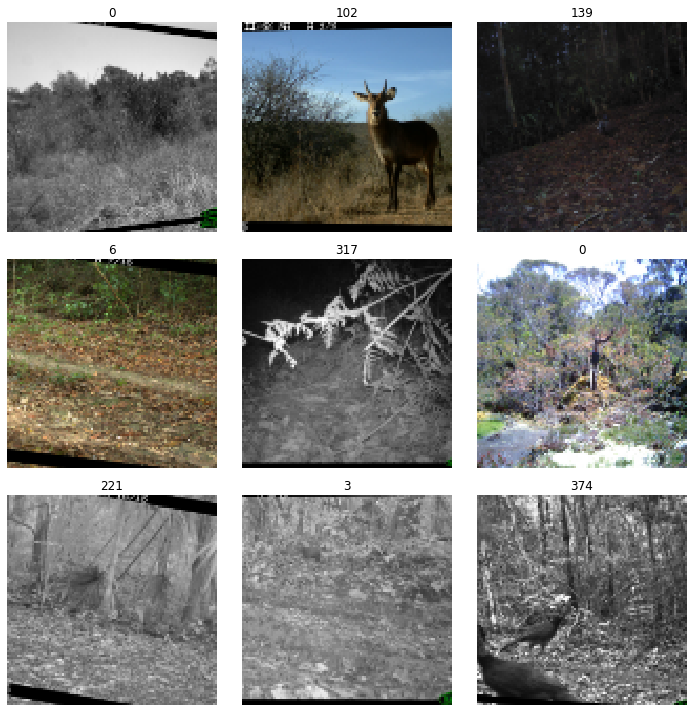

In [23]:
data.show_batch(rows=3, figsize=(10,10))

In [17]:
print(data.classes)
len(data.classes),data.c

[0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 20, 24, 25, 26, 32, 44, 50, 62, 67, 70, 71, 72, 73, 74, 77, 78, 79, 80, 83, 86, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127, 129, 130, 133, 134, 137, 139, 141, 142, 144, 145, 147, 150, 152, 153, 154, 156, 159, 161, 162, 163, 166, 167, 170, 175, 177, 198, 221, 227, 229, 230, 233, 234, 235, 240, 242, 243, 245, 250, 251, 252, 253, 256, 258, 259, 262, 265, 267, 268, 273, 286, 290, 291, 292, 294, 296, 299, 300, 301, 302, 306, 307, 309, 310, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 330, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 344, 345, 346, 347, 348, 349, 350, 352, 353, 354, 355, 356, 357, 370, 371, 372, 374, 375, 376, 377, 378, 379, 380, 382, 384, 385, 389, 390, 391, 402, 404, 405, 406, 407, 408, 409, 410, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 454, 558, 559, 561, 562, 563, 564, 565, 566, 

(215, 215)

In [26]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn = cnn_learner(data, models.resnet34, metrics=error_rate, ps=0.6)

In [27]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [28]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/data.py", line 271, in get
    res = self.open(fn)
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/data.py", line 267, in open
    return open_image(fn, convert_mode=self.convert_mode, after_open=self.after_open)
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/image.py", line 398, in open_image
    x = PIL.Image.open(fn).convert(convert_mode)
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py", line 2862, in open
    "cannot identify image file %r" % (filename if filename else fp)
PIL.UnidentifiedImageError: cannot identify image file '/home/manoj/Documents/data/data/iwildcam-2020/train/8f17b296-21bc-11ea-a13a-137349068a90.jpg'


Training Loss is greater than validation loss. Something isn't right

In [22]:
import torch
torch.cuda.empty_cache()

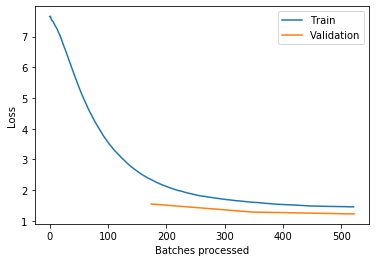

In [19]:
learn.recorder.plot_losses()

In [1]:
learn.save('stage-1.50.033010')

NameError: name 'learn' is not defined

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

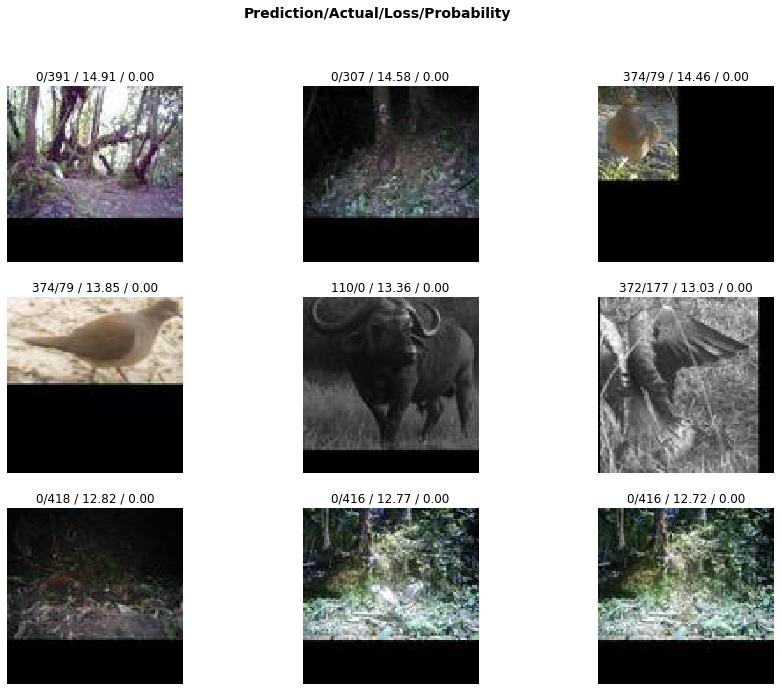

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

KeyboardInterrupt: 

In [76]:
interp.most_confused(min_val=2)

[(374, 372, 442),
 (79, 0, 263),
 (372, 374, 244),
 (24, 10, 178),
 (376, 10, 176),
 (374, 3, 175),
 (6, 10, 172),
 (558, 372, 165),
 (115, 0, 158),
 (372, 3, 147),
 (371, 10, 142),
 (371, 3, 133),
 (371, 372, 130),
 (0, 372, 122),
 (90, 96, 122),
 (380, 3, 122),
 (10, 375, 119),
 (3, 372, 118),
 (243, 10, 118),
 (375, 10, 115),
 (24, 372, 113),
 (71, 96, 111),
 (380, 372, 105),
 (115, 96, 103),
 (96, 0, 102),
 (144, 0, 94),
 (137, 0, 92),
 (3, 374, 91),
 (10, 24, 87),
 (6, 3, 82),
 (6, 372, 80),
 (2, 372, 73),
 (372, 558, 73),
 (380, 374, 73),
 (315, 317, 72),
 (91, 317, 70),
 (371, 375, 68),
 (26, 3, 66),
 (240, 372, 66),
 (290, 0, 65),
 (0, 10, 64),
 (96, 71, 60),
 (111, 0, 59),
 (103, 96, 58),
 (379, 3, 58),
 (0, 115, 57),
 (558, 3, 57),
 (8, 372, 55),
 (0, 3, 54),
 (371, 374, 54),
 (374, 558, 54),
 (6, 375, 53),
 (71, 0, 53),
 (79, 372, 53),
 (6, 374, 52),
 (96, 115, 52),
 (0, 96, 51),
 (10, 243, 51),
 (2, 3, 50),
 (240, 374, 50),
 (371, 243, 50),
 (379, 372, 50),
 (380, 10, 50),


In [23]:
learn.unfreeze()

Check the model after unfreezing

In [20]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.431768,1.203252,0.333570,01:07
1,1.392755,1.163486,0.320884,01:08
2,1.345198,1.114139,0.311592,01:07
3,1.289223,1.062707,0.302049,01:08
4,1.244391,1.015049,0.287825,01:08
5,1.196859,0.972905,0.275092,01:09
6,1.154061,0.936294,0.268072,01:08
7,1.113588,0.897897,0.256808,01:08
8,1.082625,0.875364,0.251875,01:08
9,1.059514,0.847499,0.244580,01:08


The training losses are still greater than validation losses

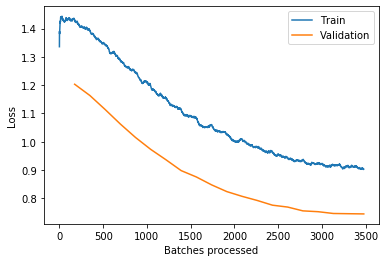

In [21]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,0.879226,0.715250,0.208814,01:29
1,0.825984,0.667385,0.196862,01:28
2,0.769924,0.650306,0.192939,01:29
3,0.719833,0.651650,0.191677,01:29
4,0.647789,0.621235,0.180022,01:28
5,0.575049,0.564505,0.162977,01:28
6,0.491229,0.529961,0.151690,01:29


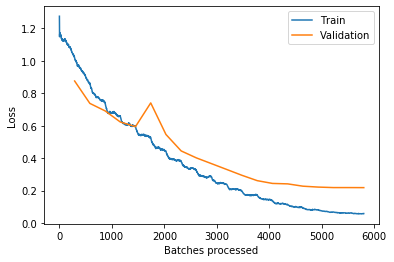

In [34]:
learn.recorder.plot_losses()

Much better! But can be better. Maybe the learning rate needs to be reduced!

In [29]:
learn.save('stage-1.50.033008');

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


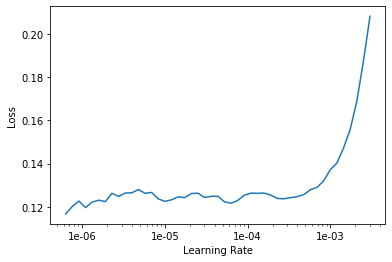

In [31]:
learn.recorder.plot()

In [41]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [42]:
learn.fit_one_cycle(2, max_lr=slice(7e-4,9e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.424102,1.213107,0.331766,01:07
1,1.149723,0.994845,0.278995,01:08


Unfreeze and rerun

In [44]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(7e-4,9e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.174495,1.285085,0.338396,01:29
1,0.922118,0.875309,0.237215,01:30
2,0.612756,0.522906,0.149042,01:30
3,0.423082,0.402010,0.114007,01:30


Training Loss is less than validation loss for one but ...

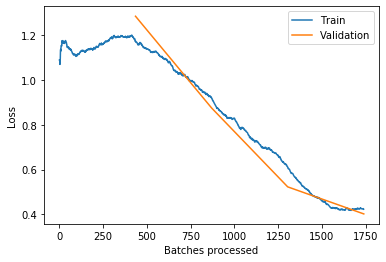

In [45]:
learn.recorder.plot_losses()

Maybe a few more fittings will make the losses better

In [46]:
learn.fit_one_cycle(4, max_lr=slice(7e-4,9e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.639077,0.697508,0.196008,01:29
1,0.608513,0.578154,0.161455,01:29
2,0.403043,0.378989,0.105908,01:29
3,0.258219,0.295441,0.081565,01:29


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f925a868208>>
Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f925a868208>>
Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch

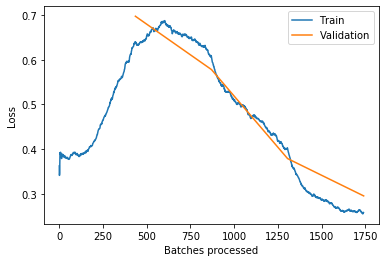

In [47]:
learn.recorder.plot_losses()

In [48]:
learn.fit_one_cycle(4, max_lr=slice(7e-4,9e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.465463,0.522253,0.142113,01:29
1,0.471195,0.421730,0.115040,01:30


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f925a868208>>
Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f925a868208>>
Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch

    self._shutdown_workers()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f925a868208>>
Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in j

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f925a868208>>
Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f9

Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f925a868208>>
Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/

    w.join()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f925a868208>>
Traceback (most recent call last):
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/manoj/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _

KeyboardInterrupt: 

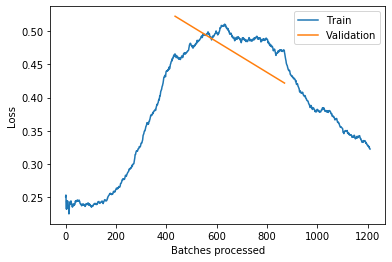

In [49]:
learn.recorder.plot_losses()

In [29]:
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-3))
learn.save('stage-1.0401')

epoch,train_loss,valid_loss,error_rate,time
0,0.159766,0.260116,0.064931,01:42
1,0.178091,0.264888,0.067982,01:43
2,0.138863,0.246882,0.060089,01:44
3,0.114472,0.232975,0.057290,01:43
4,0.101339,0.231996,0.056189,01:42


In [30]:
learn.save('stage-1.0401')

In [110]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.606065,0.538460,0.151291,02:00
1,0.488275,0.471126,0.130504,02:01


In [111]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.532872,0.473349,0.131031,02:04
1,0.525990,0.443260,0.121005,02:06
2,0.433970,0.386381,0.104508,02:03
3,0.330042,0.344057,0.092876,02:00
4,0.291332,0.334575,0.089320,02:00


In [45]:
learn.save('stage-1.103');

In [115]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.034830,0.844886,0.232672,02:01
1,0.880857,0.714994,0.198279,02:02
2,0.679673,0.573285,0.163152,02:01
3,0.576557,0.481654,0.135161,02:01
4,0.506893,0.460524,0.130274,02:01


In [142]:
learn.save('stage-1.2')

In [119]:
learn.load('stage-1.2')

Learner(data=ImageDataBunch;

Train: LabelList (174368 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
canis lupus,canis lupus,canis lupus,canis lupus,canis lupus
Path: /home/manoj/Documents/data/data/iwildcam-2020/train/28X28;

Valid: LabelList (43585 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
didelphis sp,empty,tayassu pecari,start,urocyon cinereoargenteus
Path: /home/manoj/Documents/data/data/iwildcam-2020/train/28X28;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (con

In [123]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.499413,0.468299,0.129953,02:01
1,0.528191,0.471905,0.129586,02:01
2,0.412915,0.388813,0.106092,02:01
3,0.312247,0.338621,0.090582,01:58
4,0.271372,0.325167,0.086681,02:00


In [138]:
learn.save('stage-1.2')

In [126]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.361829,0.366045,0.098382,02:00
1,0.409903,0.376553,0.099392,02:01
2,0.344346,0.330044,0.087645,02:01
3,0.241982,0.296369,0.077045,02:01
4,0.205077,0.287357,0.073764,02:01


In [228]:
learn.save('stage-1.2')

In [84]:
interp = ClassificationInterpretation.from_learner(learn)

In [85]:
interp.most_confused(min_val=2)

[(79, 0, 148),
 (90, 96, 101),
 (290, 0, 47),
 (103, 96, 42),
 (144, 0, 41),
 (115, 0, 36),
 (0, 115, 32),
 (372, 374, 32),
 (137, 0, 30),
 (24, 10, 29),
 (96, 0, 28),
 (96, 90, 25),
 (318, 91, 24),
 (374, 372, 23),
 (0, 111, 22),
 (111, 0, 22),
 (96, 111, 21),
 (0, 79, 19),
 (0, 137, 18),
 (10, 243, 17),
 (0, 310, 16),
 (72, 70, 16),
 (111, 96, 16),
 (315, 317, 16),
 (96, 115, 15),
 (259, 111, 15),
 (371, 10, 15),
 (6, 10, 14),
 (71, 96, 14),
 (375, 243, 14),
 (10, 371, 13),
 (91, 318, 13),
 (115, 96, 13),
 (375, 10, 13),
 (74, 115, 12),
 (291, 0, 12),
 (309, 0, 12),
 (6, 24, 11),
 (6, 375, 10),
 (70, 72, 10),
 (90, 0, 10),
 (111, 112, 10),
 (256, 71, 10),
 (258, 0, 10),
 (0, 112, 9),
 (2, 8, 9),
 (10, 375, 9),
 (24, 372, 9),
 (71, 90, 9),
 (112, 0, 9),
 (317, 315, 9),
 (348, 0, 9),
 (371, 24, 9),
 (0, 90, 8),
 (0, 110, 8),
 (6, 0, 8),
 (6, 371, 8),
 (70, 86, 8),
 (96, 71, 8),
 (258, 96, 8),
 (371, 3, 8),
 (371, 243, 8),
 (371, 372, 8),
 (378, 380, 8),
 (0, 96, 7),
 (0, 144, 7),
 (0, 

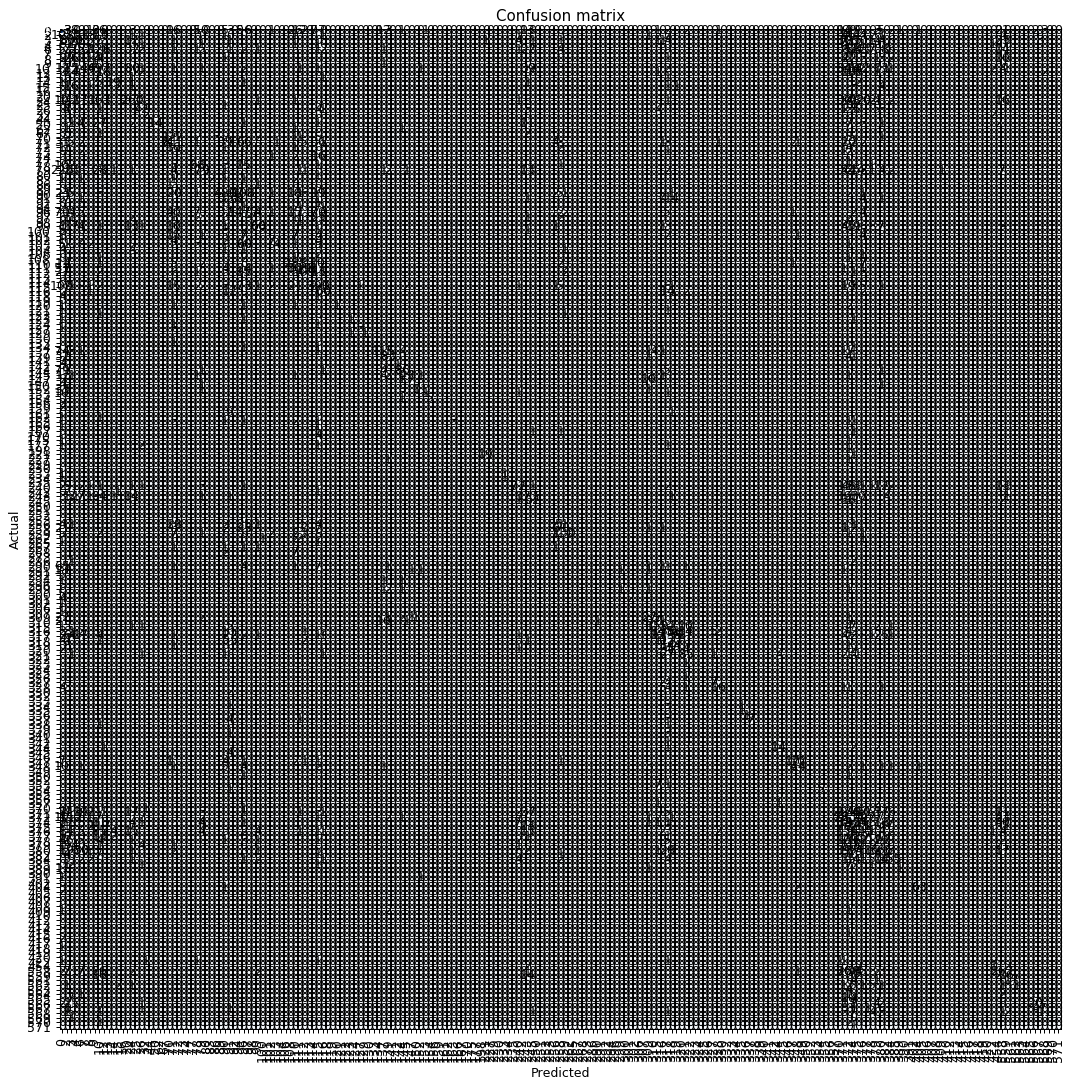

In [32]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=90)

In [134]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.204993,0.310044,0.076058,02:00
1,0.210914,0.315394,0.077664,02:01
2,0.194033,0.285507,0.069336,02:00
3,0.148089,0.260740,0.062590,01:58
4,0.122289,0.251379,0.059837,01:58


In [141]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.123082,0.286238,0.061971,02:00
1,0.152720,0.296404,0.066399,02:00
2,0.130252,0.269045,0.061030,02:00
3,0.091032,0.256849,0.055455,01:58
4,0.075965,0.258699,0.054583,01:58


In [33]:
jsonTestFilePath='/home/manoj/Documents/data/data/iwildcam-2020/iwildcam2020_test_information.json'
testData = readJSONFile(jsonTestFilePath)

testImages=testData["images"]
testCategories = testData["categories"]
testInfo = testData["info"]

# Convert to Data frame

testImages = pd.DataFrame.from_dict(testImages)
testCategories = pd.DataFrame.from_dict(testCategories)

#Remove data from memory
del testData, testInfo

# Remove Unnecessary fields from images
testDf1 = pd.DataFrame(testImages.file_name)
    

In [34]:
testImages

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name
0,1,84,2013-08-02 21:44:00.000,88037cce-21bc-11ea-a13a-137349068a90,1,88037e90-21bc-11ea-a13a-137349068a90,2771,1779,88037cce-21bc-11ea-a13a-137349068a90.jpg
1,1,84,2013-08-02 21:51:00.000,963e6b46-21bc-11ea-a13a-137349068a90,1,963e6cb8-21bc-11ea-a13a-137349068a90,2771,1779,963e6b46-21bc-11ea-a13a-137349068a90.jpg
2,1,548,2013-04-25 18:23:00.000,8a1b53ba-21bc-11ea-a13a-137349068a90,1,8a1b5554-21bc-11ea-a13a-137349068a90,2895,1865,8a1b53ba-21bc-11ea-a13a-137349068a90.jpg
3,1,181,2013-04-17 16:10:00.000,938c0d5e-21bc-11ea-a13a-137349068a90,1,938c0f02-21bc-11ea-a13a-137349068a90,2902,1818,938c0d5e-21bc-11ea-a13a-137349068a90.jpg
4,1,181,2013-04-20 03:11:00.000,95b9bd92-21bc-11ea-a13a-137349068a90,1,95b9be96-21bc-11ea-a13a-137349068a90,2212,1841,95b9bd92-21bc-11ea-a13a-137349068a90.jpg
...,...,...,...,...,...,...,...,...,...
62889,-1,5,2013-08-01 18:45:20.000,978d4224-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,978d4224-21bc-11ea-a13a-137349068a90.jpg
62890,-1,5,2013-08-01 18:45:21.000,8bd8cad4-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,8bd8cad4-21bc-11ea-a13a-137349068a90.jpg
62891,-1,5,2013-08-01 18:45:22.000,8c894fc6-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,8c894fc6-21bc-11ea-a13a-137349068a90.jpg
62892,-1,5,2013-08-01 18:45:22.000,97bffbf6-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,97bffbf6-21bc-11ea-a13a-137349068a90.jpg


In [35]:
testPath=Path("/home/manoj/Documents/data/data/iwildcam-2020/test/100X100")

In [36]:
testPath.ls()[10]

PosixPath('/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/86769580-21bc-11ea-a13a-137349068a90.jpg')

In [37]:
for i, file in enumerate(testPath.ls()):
    if (i < 10) :
        print(file)

/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/867611a0-21bc-11ea-a13a-137349068a90.jpg
/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/86761d58-21bc-11ea-a13a-137349068a90.jpg
/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/867624e2-21bc-11ea-a13a-137349068a90.jpg
/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/86762942-21bc-11ea-a13a-137349068a90.jpg
/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/86763c0c-21bc-11ea-a13a-137349068a90.jpg
/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/86765afc-21bc-11ea-a13a-137349068a90.jpg
/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/867665c4-21bc-11ea-a13a-137349068a90.jpg
/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/86767820-21bc-11ea-a13a-137349068a90.jpg
/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/86768504-21bc-11ea-a13a-137349068a90.jpg
/home/manoj/Documents/data/data/iwildcam-2020/test/100X100/8676929c-21bc-11ea-a13a-137349068a90.jpg


In [38]:
learn.predict(open_image(testPath.ls()[1]), True)[1]

Category 96

In [39]:
for i, file in enumerate(testPath.ls()):
    if (i < 10) :
        print(learn.predict(open_image(testPath.ls()[i]))[0])

0
96
374
115
371
372
111
378
71
115


In [40]:
i=0
for file in testPath.ls():
    if (i < 10) :
        print(learn.predict(open_image(file))[0])
        i=i+1

0
96
374
115
371
372
111
378
71
115


In [41]:
#df=[ {"file_name":str(file).replace(str(testPath)+'/',''), "name": learn.predict(open_image(file))[0] }
df=[ {"file_name":str(file).replace(str(testPath)+'/',''), "Id": learn.predict(open_image(file))[0] }
    for file in testPath.ls()[:]
]

In [42]:
df=pd.DataFrame(df)

In [48]:
df

,file_name,Id
0,867611a0-21bc-11ea-a13a-137349068a90.jpg,0
1,86761d58-21bc-11ea-a13a-137349068a90.jpg,96
2,867624e2-21bc-11ea-a13a-137349068a90.jpg,374
3,86762942-21bc-11ea-a13a-137349068a90.jpg,115
4,86763c0c-21bc-11ea-a13a-137349068a90.jpg,371
...,...,...
62890,995a286a-21bc-11ea-a13a-137349068a90.jpg,79
62891,995a3fda-21bc-11ea-a13a-137349068a90.jpg,0
62892,995a4dfe-21bc-11ea-a13a-137349068a90.jpg,10
62893,995a548e-21bc-11ea-a13a-137349068a90.jpg,372


In [49]:
jsonSubmissionFilePath='/home/manoj/Documents/data/data/iwildcam-2020/sample_submission.csv'
submission=pd.read_csv(jsonSubmissionFilePath)

In [50]:
submission.drop(columns=["Category"], inplace=True)
submission

,Id
0,873ff218-21bc-11ea-a13a-137349068a90
1,884103be-21bc-11ea-a13a-137349068a90
2,973feb64-21bc-11ea-a13a-137349068a90
3,8ebf4e44-21bc-11ea-a13a-137349068a90
4,95a33464-21bc-11ea-a13a-137349068a90
...,...
62865,976c0b90-21bc-11ea-a13a-137349068a90
62866,92f567fa-21bc-11ea-a13a-137349068a90
62867,9692fb2a-21bc-11ea-a13a-137349068a90
62868,8b0412f8-21bc-11ea-a13a-137349068a90


In [51]:
testXref=testImages[["file_name","id"]]

In [52]:
len(testXref)

62894

In [53]:
#testXref.groupby('file_name').first()
df.merge(testXref, on='file_name')

,file_name,Id,id
0,867611a0-21bc-11ea-a13a-137349068a90.jpg,0,867611a0-21bc-11ea-a13a-137349068a90
1,86761d58-21bc-11ea-a13a-137349068a90.jpg,96,86761d58-21bc-11ea-a13a-137349068a90
2,867624e2-21bc-11ea-a13a-137349068a90.jpg,374,867624e2-21bc-11ea-a13a-137349068a90
3,86762942-21bc-11ea-a13a-137349068a90.jpg,115,86762942-21bc-11ea-a13a-137349068a90
4,86763c0c-21bc-11ea-a13a-137349068a90.jpg,371,86763c0c-21bc-11ea-a13a-137349068a90
...,...,...,...
62889,995a286a-21bc-11ea-a13a-137349068a90.jpg,79,995a286a-21bc-11ea-a13a-137349068a90
62890,995a3fda-21bc-11ea-a13a-137349068a90.jpg,0,995a3fda-21bc-11ea-a13a-137349068a90
62891,995a4dfe-21bc-11ea-a13a-137349068a90.jpg,10,995a4dfe-21bc-11ea-a13a-137349068a90
62892,995a548e-21bc-11ea-a13a-137349068a90.jpg,372,995a548e-21bc-11ea-a13a-137349068a90


In [54]:
#df1=df.merge(testImages, on='file_name')[["id","name"]]
df1=df.merge(testXref, on='file_name')[["id","Id"]]
#df1=df1.rename(columns={"id":"Id"})
df1=df1.rename(columns={"Id":"Category", "id":"Id"})

In [55]:
df1

,Id,Category
0,867611a0-21bc-11ea-a13a-137349068a90,0
1,86761d58-21bc-11ea-a13a-137349068a90,96
2,867624e2-21bc-11ea-a13a-137349068a90,374
3,86762942-21bc-11ea-a13a-137349068a90,115
4,86763c0c-21bc-11ea-a13a-137349068a90,371
...,...,...
62889,995a286a-21bc-11ea-a13a-137349068a90,79
62890,995a3fda-21bc-11ea-a13a-137349068a90,0
62891,995a4dfe-21bc-11ea-a13a-137349068a90,10
62892,995a548e-21bc-11ea-a13a-137349068a90,372


In [56]:
#df2=submission.merge(df1, on="Id")[["Id","Category"]]
df2=submission.merge(df1, on="Id")

In [57]:
df2

,Id,Category
0,873ff218-21bc-11ea-a13a-137349068a90,0
1,884103be-21bc-11ea-a13a-137349068a90,96
2,973feb64-21bc-11ea-a13a-137349068a90,3
3,8ebf4e44-21bc-11ea-a13a-137349068a90,24
4,95a33464-21bc-11ea-a13a-137349068a90,24
...,...,...
62865,976c0b90-21bc-11ea-a13a-137349068a90,3
62866,92f567fa-21bc-11ea-a13a-137349068a90,10
62867,9692fb2a-21bc-11ea-a13a-137349068a90,0
62868,8b0412f8-21bc-11ea-a13a-137349068a90,0


In [58]:
#df["file_name"]

In [59]:
df2.to_csv("submission.2020033008.csv", index=False)

In [ ]:
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
#y = torch.argmax(preds, dim=1)

In [47]:
!pwd

/home/manoj/Documents/GitHub/IWildCam2020/src


In [ ]:
learn1 = cnn_learner(data, models.resnet34, metrics=error_rate)